# Tests with Port Angeles data

In [1]:
import dascore as dc
# from dascore.utils.downloader import fetch
import h5py
import numpy as np
import matplotlib.pyplot as plt

## Using dascore

In [2]:
data_path = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring"
spool = dc.spool(data_path)
patch = spool[0]

In [3]:
def loadBradyHShdf5(file: str, normalize: bool = "no") -> tuple:
    """
    Load brady hotspring h5py data file and return the data and timestamps.

    Parameters
    ----------
    file : str
        path to brady hotspring h5py data file
    normalize : str, optional
        "yes" or "no". Indicates whether or not to remove laser drift and
        normalize. The default is 'yes'.

    Returns
    -------
    data : np array
        channel by samples numpy array of data
    timestamp_arr : numpy array
        array of the timestamps corresponding to the various samples in the
        data. Timestamps for brady hotspring data are with respect to the
        beginning time of the survey.

    """

    with h5py.File(file, "r") as open_file:
        dataset = open_file["das"]
        time = open_file["t"]
        data = np.array(dataset)
        timestamp_arr = np.array(time)
    data = np.transpose(data)
    if normalize == "yes":
        nSamples = np.shape(data)[1]
        # get rid of laser drift
        med = np.median(data, axis=0)
        for i in range(nSamples):
            data[:, i] = data[:, i] - med[i]

        max_of_rows = abs(data[:, :]).sum(axis=1)
        data = data / max_of_rows[:, np.newaxis]
    return data, timestamp_arr

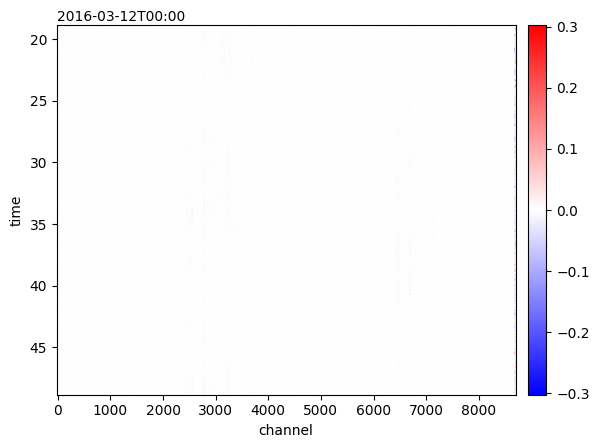

<Axes: xlabel='channel', ylabel='time'>

In [4]:
patch.viz.waterfall(show=True, scale=0.2)

In [5]:
# file= r"D:\CSM\Mines_Research\Test_data\Port_Angeles\Cascadia_DAS_1078DT_25PR_14GL_5DEC_2023-05-01T122349Z.h5"
file= r"D:\CSM\Mines_Research\Test_data\Port_Angeles\Cascadia_DAS_1078DT_25PR_14GL_5DEC_2023-04-25T112349Z.h5"

In [6]:
patch = dc.spool(file)[0]
# patch = patch.detrend("distance")
patch = patch.pass_filter(distance=(0.1, None))

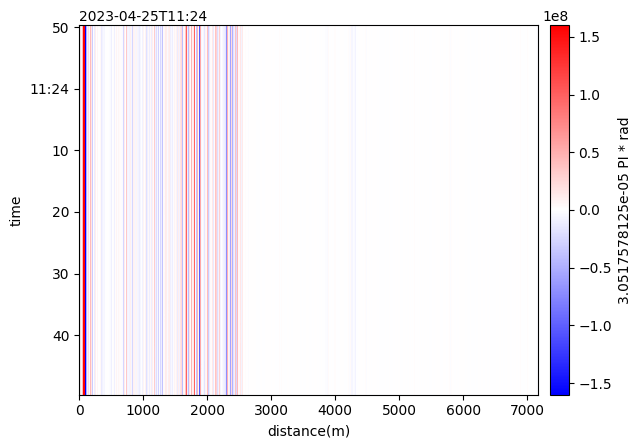

<Axes: xlabel='distance(m)', ylabel='time'>

In [7]:
patch.viz.waterfall(show=True, scale=0.1)

In [6]:
f = h5py.File(file, 'r')

In [10]:
list(f.keys())

['Acquisition']

In [14]:
list(f['Acquisition'].keys())

['Custom', 'Raw[0]']

In [17]:
f['Acquisition']['Raw[0]'].keys()

<KeysViewHDF5 ['Custom', 'RawData', 'RawDataTime']>

In [30]:
# f['Acquisition']['Raw[0]']['RawData']
f['Acquisition']['Raw[0]']['RawDataTime']

<HDF5 dataset "RawDataTime": shape (19816,), type "<i8">

In [31]:
data = np.array(f['Acquisition']['Raw[0]']['RawData'])
timestamp_arr = np.array(f['Acquisition']['Raw[0]']['RawDataTime'])

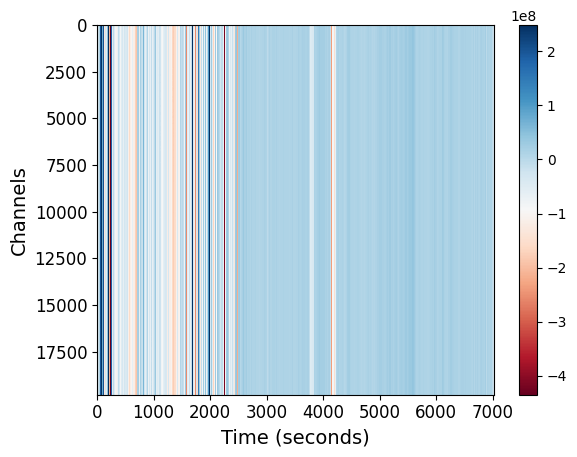

In [29]:
v_min = np.percentile(data, 0.5)
v_max = np.percentile(data, 99)
tick_size = 12
fsize = 14

fig2 = plt.figure()
img2 = plt.imshow(data, cmap="RdBu",
           vmin=v_min, 
           vmax=v_max, aspect='auto', interpolation='none')
         #   extent=(0, 90, 5000, 1))
plt.xlabel('Time (seconds)',fontsize=fsize)
plt.ylabel('Channels',fontsize=fsize)
# plt.title('Background noise',fontsize=fsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=tick_size)

In [32]:
timestamp_arr

array([1682943829678000, 1682943829680000, 1682943829682000, ...,
       1682943869304000, 1682943869306000, 1682943869308000], dtype=int64)